In [183]:
import os
import torch
import math
import numpy as np
import functools
import operator
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

In [184]:
help(torch.compile)

Help on function compile in module torch:

compile(model: Optional[Callable] = None, *, fullgraph: bool = False, dynamic: Optional[bool] = None, backend: Union[str, Callable] = 'inductor', mode: Optional[str] = None, options: Optional[Dict[str, Union[str, int, bool]]] = None, disable: bool = False) -> Callable
    Optimizes given model/function using TorchDynamo and specified backend.
    If you are compiling an :class:`torch.nn.Module`, you can also use :meth:`torch.nn.Module.compile`
    to compile the module inplace without changing its structure.
    
    Concretely, for every frame executed within the compiled region, we will attempt
    to compile it and cache the compiled result on the code object for future
    use.  A single frame may be compiled multiple times if previous compiled
    results are not applicable for subsequent calls (this is called a "guard
    failure), you can use TORCH_LOGS=guards to debug these situations.
    Multiple compiled results can be associated wi

In [185]:
torch.backends.cudnn.benchmark = True

In [186]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [187]:
def prod(x):
    return functools.reduce(operator.mul, x, 1)

class QConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else tuple(kernel_size)
        super(QConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        scale = 1 / math.sqrt(in_channels * prod(self.kernel_size))
        self.weight = nn.Parameter(torch.distributions.Uniform(
            low=-scale,
            high=scale).sample((out_channels, in_channels, *kernel_size)))
        self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), fill_value=-8.))
        self.b = nn.Parameter(torch.full((out_channels, 1, 1, 1), fill_value=2.))  # start with 2 bits per weight

    def qbits(self):
        return F.relu(self.b).sum() * prod(self.weight.shape[1:])

    def qweight(self):
        qmin = -2**(F.relu(self.b)-1)
        qmax = 2**(F.relu(self.b)-1) - 1
        return torch.min(torch.max(2**-self.e * self.weight, qmin), qmax)
  
    def __call__(self, x):
        qw = self.qweight()
        w = (qw.round() - qw).detach() + qw  # straight through estimator
        return F.conv2d(x, 2**self.e * w)

In [188]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_block = nn.Sequential(
            QConv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True),
            QConv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            QConv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
        
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x

In [189]:
batch_size_train = 64
batch_size_test = 1000


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [190]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [191]:
network = ConvNet()
compiled_network = torch.compile(network, mode='max-autotune')
compiled_network.to(device)
optimizer = optim.Adam(network.parameters(), lr=3e-4)

In [192]:
def train_step(output, target, model):
    optimizer.zero_grad()
    loss = compression_loss(output, target, model)
    Q = functools.reduce(lambda x,y: x+y, [l.qbits() for l in model.modules() if isinstance(l, QConv2d)]) / weight_count
    # loss = loss + 0.05*Q   # hyperparameter determines compression vs accuracy
    loss.backward()
    optimizer.step()
    return loss, Q

In [193]:
weight_count = sum(t.numel() for t in network.parameters())
len(list(compiled_network.parameters())), weight_count

(22, 905354)

In [194]:
def compression_loss(output, target, model, compression_factor=1e-4):
    loss = F.cross_entropy(output, target)
    Q = functools.reduce(lambda x,y: x+y, [l.qbits() for l in model.modules() if isinstance(l, QConv2d)]) / weight_count
    return compression_factor * Q + loss

In [195]:
train_losses = []
test_losses = []
model_size = []
train_acc = []

In [196]:
log_interval = 10
epochs = 50
running_loss = 0.0
running_corrects = 0.0
val_running_loss = 0.0
val_running_corrects = []

for epoch in range(1, epochs+1):
    compiled_network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = compiled_network(data).to(device)
        loss, Q = train_step(output, target, compiled_network)
        model_bytes = Q.item() / 8 * weight_count
        train_losses.append(loss.item())
        _, preds = torch.max(output, 1)
        running_corrects = (preds== target).sum().item() / preds.size(0)
        model_size.append(model_bytes)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), 
                running_corrects))
        train_acc.append(running_corrects)
        
    compiled_network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = compiled_network(data).to(device)
            test_loss += compression_loss(output, target, compiled_network)
            preds = output.data.max(1, keepdim=True)[1]
            val_acc = (preds == target).sum().item() / preds.size(0)
            val_running_corrects.append(val_acc)
            test_losses.append(test_loss.item())
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:.0f}%)\n'.format(
        test_loss, val_acc))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.514549 Acc: 0.093750
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.118062 Acc: 0.890625
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.992626 Acc: 0.921875
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.808991 Acc: 0.921875
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.737388 Acc: 0.921875
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.736356 Acc: 0.875000
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.541417 Acc: 0.984375
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.537029 Acc: 1.000000
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.486948 Acc: 0.984375
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.419566 Acc: 0.984375
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.415943 Acc: 0.984375
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.378377 Acc: 0.984375
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.363144 Acc: 0.968750
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.317612 Acc: 1.000000
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.337742 Acc: 0.984375
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.293618 Acc: 1.000000
Train

In [201]:
test_accs = [d / 100 for d in val_running_corrects]

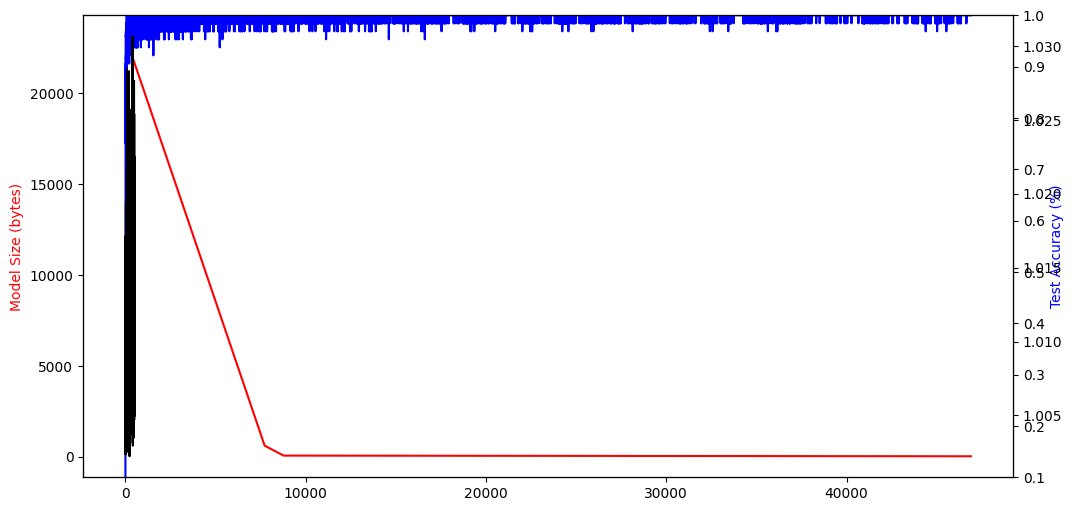

In [202]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel("Model Size (bytes)")
ax1.yaxis.label.set_color("red")
ax1.plot(model_size, color="red")
ax2 = ax1.twinx()
ax2.plot(train_acc, color="blue")
plt.ylim(0.1, 1)
ax2.set_ylabel("Train Accuracy (%)")
ax2.yaxis.label.set_color("blue")
ax3 = ax1.twinx()
ax3.plot(test_accs, color="black")
ax2.set_ylabel("Test Accuracy (%)")
ax2.yaxis.label.set_color("blue")